# Glide VS ComposeGlide

In [1]:
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)
from IPython.display import display
from matplotlib import pyplot as plt
from PIL import Image
from compose_glide import ComposeGlide

In [2]:
PROMPT = "A pink sky in the horizon AND A sailboat at the sea AND Overwater bungalows"
NUM_IMAGES = 1
UPSAMPLE = True

## Glide (OpenAI)

The standard implementation of GLIDE, based on the original code from OpenAI, pre-trained.

In [3]:
has_cuda = th.cuda.is_available()
device = th.device('mps')

In [4]:
# Create base model.
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = '100' # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [5]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [6]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [7]:
# Sampling parameters
prompt = PROMPT
batch_size = 1
guidance_scale = 3.0

# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.997

  0%|          | 0/100 [00:00<?, ?it/s]

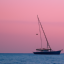

In [8]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
tokens = model.tokenizer.encode(prompt)
tokens, mask = model.tokenizer.padded_tokens_and_mask(
    tokens, options['text_ctx']
)

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
    [], options['text_ctx']
)

# Pack the tokens together into model kwargs.
model_kwargs = dict(
    tokens=th.tensor(
        [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size + [uncond_mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
model.del_cache()
samples = diffusion.p_sample_loop(
    model_fn,
    (full_batch_size, 3, options["image_size"], options["image_size"]),
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model.del_cache()

# Show the output
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

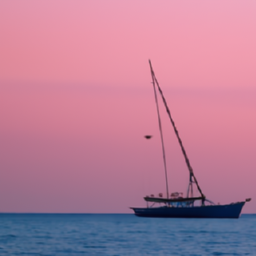

In [9]:
##############################
# Upsample the 64x64 samples #
##############################

tokens = model_up.tokenizer.encode(prompt)
tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
    tokens, options_up['text_ctx']
)

# Create the model conditioning dict.
model_kwargs = dict(
    # Low-res image to upsample.
    low_res=((samples+1)*127.5).round()/127.5 - 1,

    # Text tokens
    tokens=th.tensor(
        [tokens] * batch_size, device=device
    ),
    mask=th.tensor(
        [mask] * batch_size,
        dtype=th.bool,
        device=device,
    ),
)

# Sample from the base model.
model_up.del_cache()
up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * upsample_temp,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=model_kwargs,
    cond_fn=None,
)[:batch_size]
model_up.del_cache()

# Show the output
show_images(up_samples)

## Compose GLIDE (Mine)

Compose GLIDE implementation, based on Nan Lui et al. Improved image generatiion using composable diffusion.

In [10]:
compose_glide = ComposeGlide(model_name='base', verbose=True)
print(compose_glide)

            ComposeGLIDE Instance Configuration             
Device:                        mps                         
Verbose:                       True                        
------------------------------------------------------------
Base Model                                                  
  Parameters:                  385,030,726                 
  FP16 Enabled:                False                       
  Timestep Respacing:          100                         
  Image Size:                  64                          
------------------------------------------------------------
Upsampler Model                                             
  Parameters:                  398,361,286                 
  FP16 Enabled:                False                       
  Timestep Respacing:          fast27                      
  Image Size:                  256                         


In [11]:
print(f"Generating {NUM_IMAGES} image(s) for prompt: '{PROMPT}'.")
PROMPT = PROMPT.lower()
result, attention_data = compose_glide.generate(
    PROMPT, 
    num_images=NUM_IMAGES, 
    upsample=UPSAMPLE, 
    upsample_temp=0.995,
    save_intermediate_steps=10,
    return_attention_maps=True
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Generating 1 image(s) for prompt: 'A pink sky in the horizon AND A sailboat at the sea AND Overwater bungalows'.
CLIP model loaded from cache: clip_model_cache
Using prompts: ['a pink sky in the horizon', 'a sailboat at the sea', 'overwater bungalows'] with weights: [5.870139232222607, 5.6447427812976505, 6.485117986479742]
Generating base image 1/1...


  0%|          | 0/100 [00:00<?, ?it/s]

Upsampling base image 1/1...


  0%|          | 0/27 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

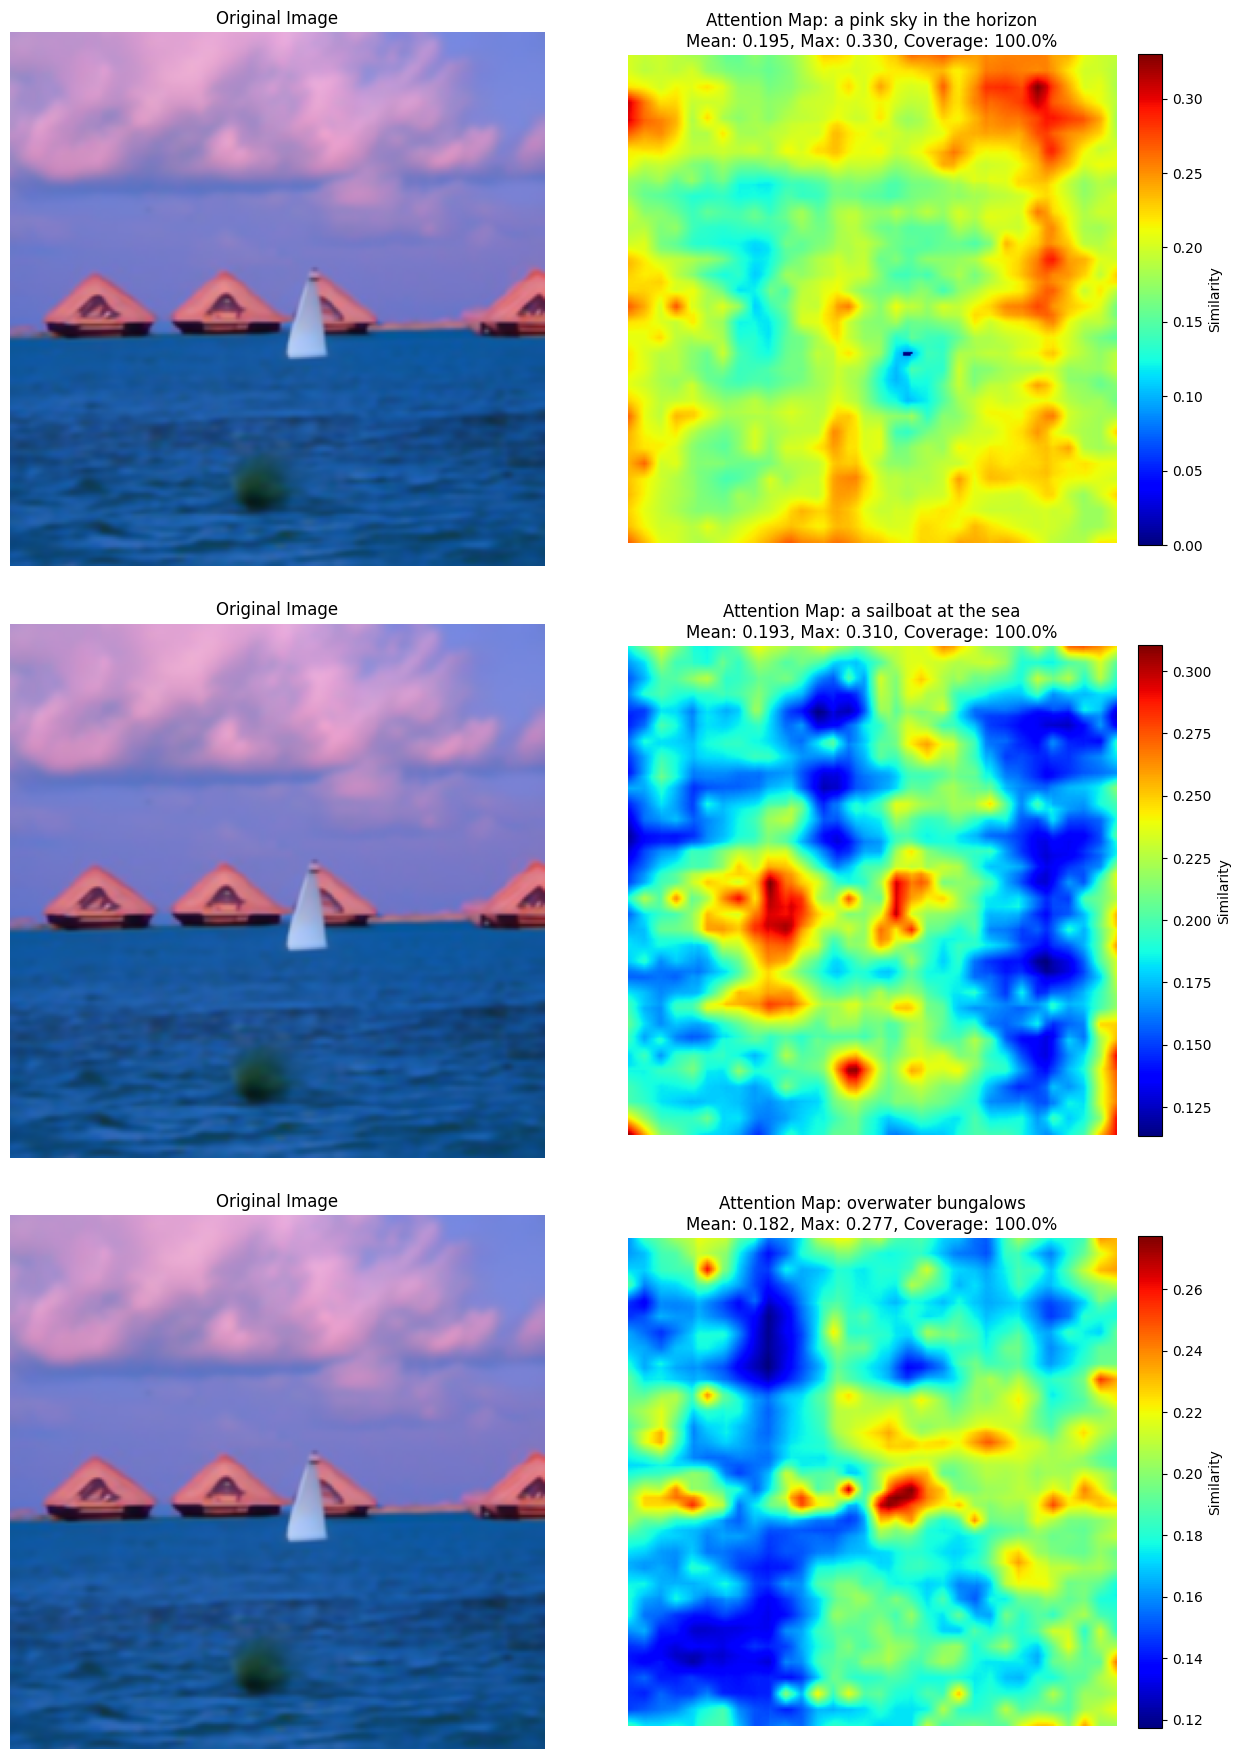

Attention map 1 displayed


In [12]:
if result.nelement() > 0:
    
    has_attention = attention_data is not None and len(attention_data) == len(result)
    
    for i, sample_tensor in enumerate(result):
        if has_attention:
            attn_maps = attention_data[i]
            
            plt.figure(figsize=(8, 8))
            
            compose_glide.visualize_attention_maps(
                sample_tensor, 
                attn_maps,
                PROMPT,
                output_path=None,
                show_plot=False
            )
            
            plt.tight_layout()
            plt.show()
            
            print(f"Attention map {i+1} displayed")
        else:
            print("Couldn't load the attention map")
else:
    print("No images were generated.")

## Compose GLIDE (Mine) - Face Generation Extension

Extension of Compose GLIDE implementation, with facial generation ability (fine-tuned).

In [13]:
compose_glide = ComposeGlide(model_name='glide_faces', verbose=True)
print(compose_glide)

            ComposeGLIDE Instance Configuration             
Device:                        mps                         
Verbose:                       True                        
------------------------------------------------------------
Base Model                                                  
  Parameters:                  385,030,726                 
  FP16 Enabled:                False                       
  Timestep Respacing:          100                         
  Image Size:                  64                          
------------------------------------------------------------
Upsampler Model                                             
  Parameters:                  398,361,286                 
  FP16 Enabled:                False                       
  Timestep Respacing:          fast27                      
  Image Size:                  256                         


In [14]:
PROMPT = "a woman AND smiling AND glasses"
print(f"Generating {NUM_IMAGES} image(s) for prompt: '{PROMPT}'.")
PROMPT = PROMPT.lower()
result, attention_data = compose_glide.generate(
    PROMPT, 
    num_images=NUM_IMAGES, 
    upsample=UPSAMPLE, 
    upsample_temp=0.995,
    save_intermediate_steps=10,
    return_attention_maps=True
)

Generating 1 image(s) for prompt: 'a woman AND smiling AND glasses'.
CLIP model loaded from cache: clip_model_cache
Using prompts: ['a woman', 'smiling', 'glasses'] with weights: [5.900531948591946, 5.801069331625385, 6.29839871978267]
Generating base image 1/1...


  0%|          | 0/100 [00:00<?, ?it/s]

Upsampling base image 1/1...


  0%|          | 0/27 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

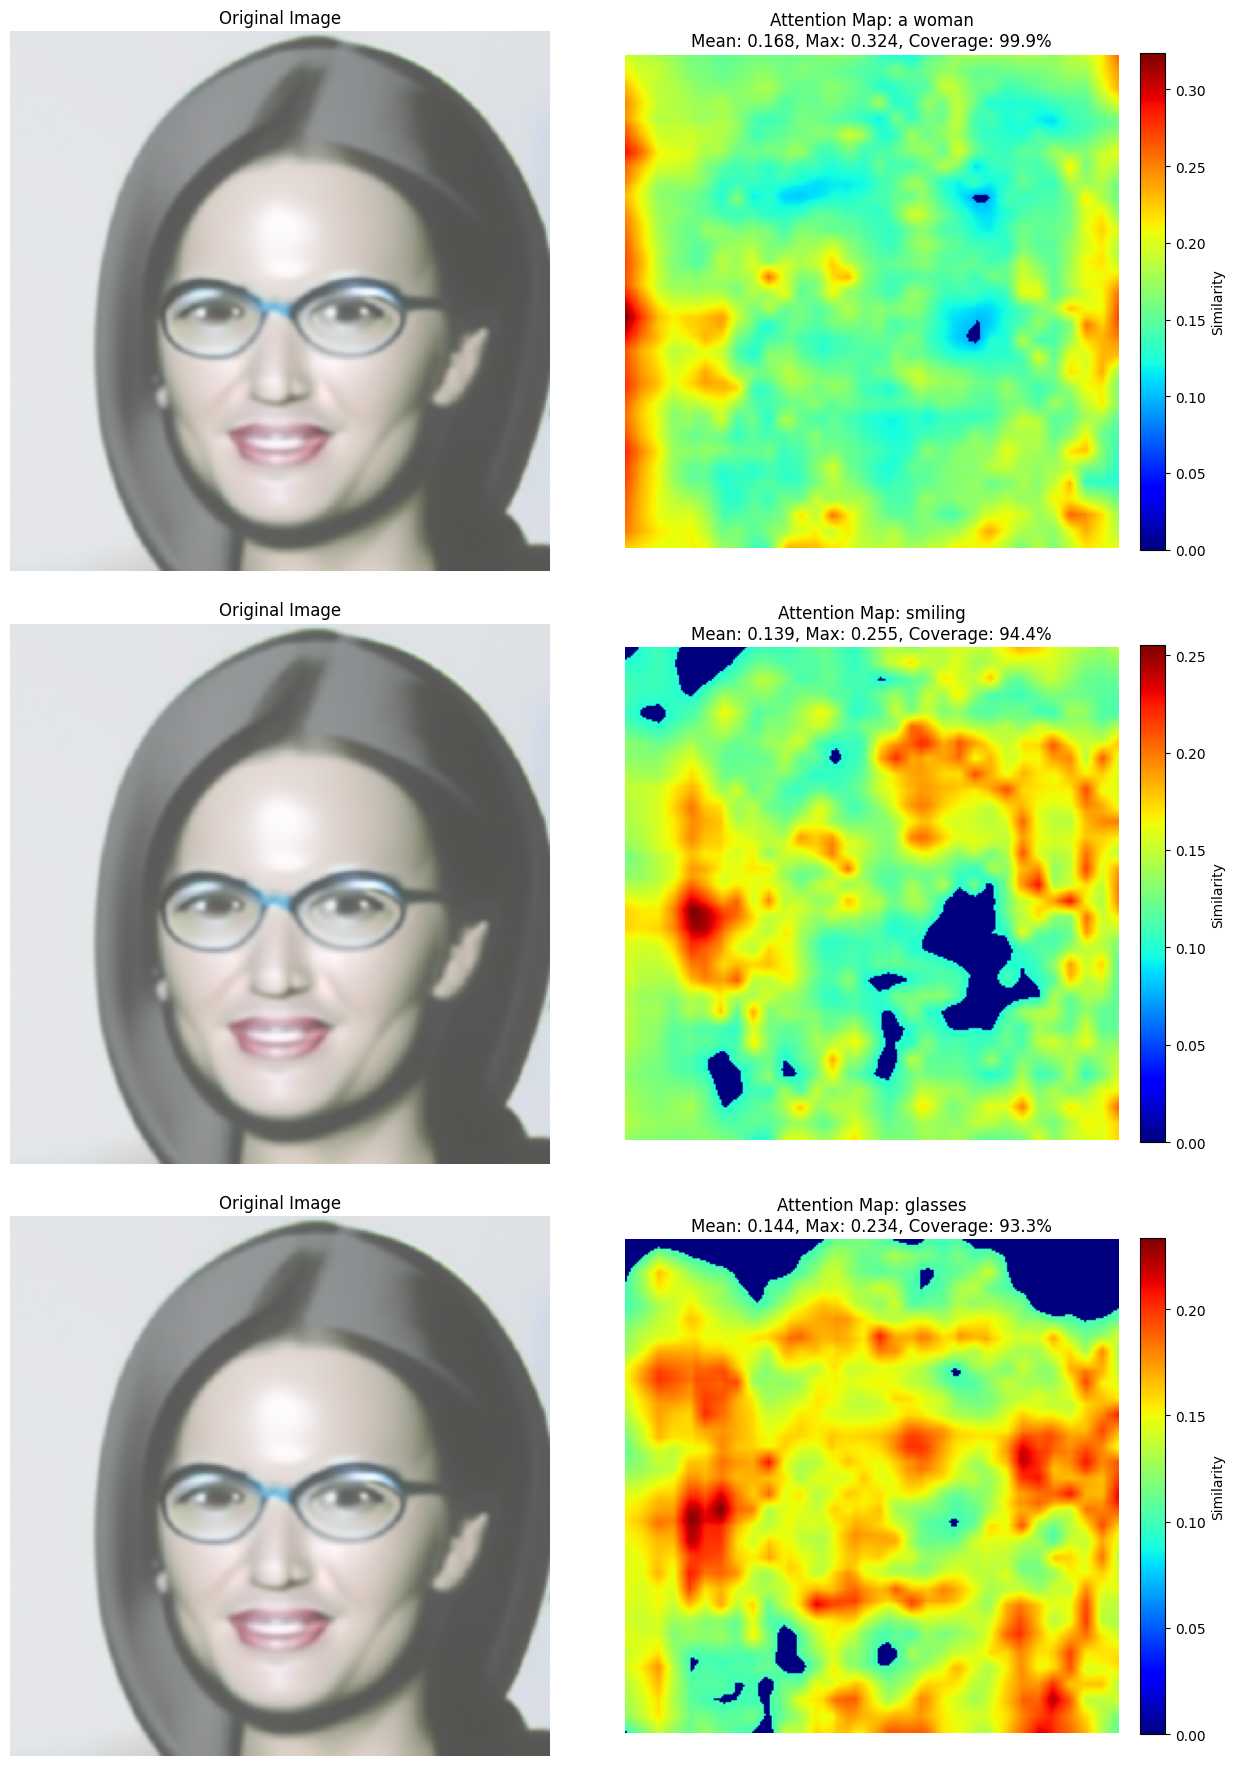

Attention map 1 displayed


In [15]:
if result.nelement() > 0:
    
    has_attention = attention_data is not None and len(attention_data) == len(result)
    
    for i, sample_tensor in enumerate(result):
        if has_attention:
            attn_maps = attention_data[i]
            
            plt.figure(figsize=(8, 8))
            
            compose_glide.visualize_attention_maps(
                sample_tensor, 
                attn_maps,
                PROMPT,
                output_path=None,
                show_plot=False
            )
            
            plt.tight_layout()
            plt.show()
            
            print(f"Attention map {i+1} displayed")
        else:
            print("Couldn't load the attention map")
else:
    print("No images were generated.")